In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
import plotting_utils
import utils

In [3]:

def read_fixed_demand_output(output_directory, last_iter=-1):
    drt_legs = []
    global_stats = []
    drt_trips_stats = []
    drt_simulated_predictions = []
    
    iter_0_path = os.path.join(output_directory,'ITERS','it.0')
    binned = '0.drt_zonalAndTimeBinWaitingTime.csv' in os.listdir(iter_0_path)
    iter_0_path += '/0.'
    
    
    global_stats = global_stats.append(pd.read_csv(iter_0_path + 'drt_globalStats.csv', sep=';'))
    drt_legs = pd.read_csv(iter_0_path + 'drt_legs_drt.csv', sep=';')
    drt_trips_stats = pd.read_csv(iter_0_path + 'drt_drtTripsStats.csv', sep=';')
    drt_simulated_predictions = pd.read_csv(iter_0_path + 'drt_simulatedTrips.csv', sep=';')

        
    d = {'drt_legs': drt_legs,
         'global_stats': global_stats,
         'drt_trips_stats': drt_trips_stats,
         'drt_simulated_predictions': drt_simulated_predictions
        }
    
    if binned:
        binned_wait_time = pd.read_csv(iter_0_path + 'drt_zonalAndTimeBinWaitingTime.csv', sep=';')
        binned_delay_factor = pd.read_csv(iter_0_path + 'drt_distanceAndTimeBinDelayFactor.csv', sep=';')
        d['binned_wait_time'] = binned_wait_time
        d['binned_delay_factor'] = binned_delay_factor
    
    if 'drt_link2FixedZones.csv' in os.listdir(output_directory):
        link2zones_csv = pd.read_csv(os.path.join(output_directory,'drt_link2FixedZones.csv'), sep=';')
        link2zones_csv = link2zones_csv.set_index('link_id')
        link2zones = {}
        for link_id, zone in link2zones_csv.iterrows():
            link2zones[link_id] = zone.zone
        fixed_zones = gpd.read_file(os.path.join(output_directory,'drt_FixedZones.shp'))
        d['link2zones'] = link2zones
        d['fixedZones'] = fixed_zones
    
    #Read stopwatch.txt
    stopwatch = pd.read_csv(os.path.join(output_directory,'stopwatch.txt'), sep='\t')
    d['stopwatch'] = stopwatch
    
    return d

In [4]:
scratch_folder = '/cluster/scratch/mfrancesc/IVT/SA_scenario'

In [5]:
configs = ['global_average', 'zonal_hex', 'zonal_square', 'zonal_TAZ', 'dynamic_CN_k500_expDecay', 'dynamic_CN_k1000_expDecay', 'dynamic_CN_k2000_expDecay', 'dynamic_PN_km500_expDecay', 'dynamic_PN_km1000_expDecay', 'dynamic_PN_km2000_expDecay', 'dynamic_FD_expDecay']

In [6]:
fd_values = [100000, 200000, 300000, 400000, 500000]

In [7]:
outputs = {}
for fd_value in fd_values:
    outputs[fd_value] = {}
    for c in tqdm(configs):
        path = os.path.join(scratch_folder,f'fixedDemand/fixedDemand_{fd_value}/{c}')
        outputs[fd_value][c] = read_fixed_demand_output(path)

100%|██████████| 11/11 [01:32<00:00,  8.42s/it]


In [8]:
def combine_simulated_predictions_and_stats(simulated_predictions, stats):
    simulated_predictions = simulated_predictions.copy(deep=True)
    stats = stats.copy(deep=True)
    
    simulated_predictions = simulated_predictions.add_suffix('_pred')
    simulated_predictions = simulated_predictions.rename(index=str, columns={'personId_pred':'personId', 'startTime_pred':'startTime'})

    stats = stats.add_suffix('_stats')
    stats = stats.rename(index=str, columns={'personId_stats':'personId', 'startTime_stats':'startTime'})
    
    return pd.merge(simulated_predictions, stats, on=['personId','startTime'], validate='one_to_one')

In [9]:
def compute_stats_table(outputs_dict):
    description = pd.DataFrame()
    fd_values = list(outputs_dict.keys())
    configs = list(outputs_dict[fd_values[0]].keys())
    
    for fd_value in fd_values:
        for c in configs:
            o = outputs_dict[fd_value][c]
            simulated = o['drt_simulated_predictions']
            #merged = combine_simulated_predictions_and_stats(o['drt_simulated_predictions'], o['drt_trips_stats'])
            true_labels = simulated['real_waiTime'] / 60
            predicted_labels = simulated['predicted_waitTime'] / 60
            errors = true_labels - predicted_labels
            current_description = pd.Series(errors).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
            # Add mse, rmse, mae
            current_description['MSE'] = np.mean(errors**2)
            current_description['RMSE'] = np.sqrt(current_description['MSE'])
            current_description['MAE'] = np.mean(np.abs(errors))
            # Add percentage of errors below 0
            current_description['% errors < 0'] = np.sum(errors < 0)/len(errors) * 100
            current_description = pd.DataFrame(current_description).T
            full_title = str(fd_value) + '_' + c
            current_description['Demand'] = fd_value
            current_description['Method'] = c
            description = pd.concat([description, current_description], axis=0)
    description = description.set_index(['Demand', 'Method'])
    return description

In [10]:
compute_stats_table(outputs)

count          mean        std  \
Demand Method                                                          
100000 global_average               98183.0 -9.193062e-16  11.597574   
       zonal_hex                    98183.0 -4.216231e-16   7.720690   
       zonal_square                 98183.0 -3.193428e-16   7.422315   
       zonal_TAZ                    98183.0 -9.311822e-01   7.312045   
       dynamic_CN_k500_expDecay     98183.0  1.446051e-01   7.499504   
       dynamic_CN_k1000_expDecay    98183.0  1.392310e-01   7.522551   
       dynamic_CN_k2000_expDecay    98183.0  1.401290e-01   7.527326   
       dynamic_PN_km500_expDecay    98183.0  1.465162e-01   7.481747   
       dynamic_PN_km1000_expDecay   98183.0  1.464348e-01   7.481762   
       dynamic_PN_km2000_expDecay   98183.0  1.465858e-01   7.481730   
       dynamic_FD_expDecay          98183.0  1.448827e-01   7.409147   
200000 global_average              196199.0  2.442980e-14  11.497595   
       zonal_hex                   196199.0  1.115978e-16   8.154883   
       zonal_square                196199.0 -8.773183e-17   7.903116   
       zonal_TAZ                   196199.0 -8.755837e-01   7.969271   
       dynamic_CN_k500_expDecay    196199.0  1.250301e-01   7.917131   
       dynamic_CN_k1000_expDecay   196199.0  1.138880e-01   7.955395   
       dynamic_CN_k2000_expDecay   196199.0  1.092260e-01   7.974273   
       dynamic_PN_km500_expDecay   196199.0  1.251943e-01   7.915779   
       dynamic_PN_km1000_expDecay  196199.0  1.159342e-01   7.940460   
       dynamic_PN_km2000_expDecay  196199.0  1.159413e-01   7.940545   
       dynamic_FD_expDecay         196199.0  1.238741e-01   7.888105   
300000 global_average              294281.0 -4.164178e-15  11.127912   
       zonal_hex                   294281.0  3.058996e-16   8.151232   
       zonal_square                294281.0  7.078119e-17   7.936707   
       zonal_TAZ                   294281.0 -7.895296e-01   8.060097   
       dynamic_CN_k500_expDecay    294281.0  1.179052e-01   7.901126   
       dynamic_CN_k1000_expDecay   294281.0  9.234095e-02   7.948947   
       dynamic_CN_k2000_expDecay   294281.0  8.341368e-02   7.976586   
       dynamic_PN_km500_expDecay   294281.0  1.168208e-01   7.900350   
       dynamic_PN_km1000_expDecay  294281.0  9.305883e-02   7.945087   
       dynamic_PN_km2000_expDecay  294281.0  8.675390e-02   7.953329   
       dynamic_FD_expDecay         294281.0  9.799613e-02   7.904986   
400000 global_average              392280.0  4.604680e-14  11.549425   
       zonal_hex                   392280.0  1.840704e-16   8.753521   
       zonal_square                392280.0  3.127326e-16   8.541594   
       zonal_TAZ                   392280.0 -7.005799e-01   8.696400   
       dynamic_CN_k500_expDecay    392280.0  1.399147e-01   8.462415   
       dynamic_CN_k1000_expDecay   392280.0  8.336932e-02   8.541945   
       dynamic_CN_k2000_expDecay   392280.0  7.761811e-02   8.572637   
       dynamic_PN_km500_expDecay   392280.0  1.402471e-01   8.462437   
       dynamic_PN_km1000_expDecay  392280.0  8.418070e-02   8.540880   
       dynamic_PN_km2000_expDecay  392280.0  7.891192e-02   8.559481   
       dynamic_FD_expDecay         392280.0  9.350207e-02   8.517520   
500000 global_average              490533.0  2.621331e-14  11.688068   
       zonal_hex                   490533.0  4.793306e-17   9.003206   
       zonal_square                490533.0 -2.803594e-17   8.799152   
       zonal_TAZ                   490533.0 -6.121962e-01   8.978544   
       dynamic_CN_k500_expDecay    490533.0  1.600557e-01   8.644832   
       dynamic_CN_k1000_expDecay   490533.0  6.747549e-02   8.783832   
       dynamic_CN_k2000_expDecay   490533.0  6.121650e-02   8.814923   
       dynamic_PN_km500_expDecay   490533.0  1.574319e-01   8.644758   
       dynamic_PN_km1000_expDecay  490533.0  6.824691e-02   8.782929   
       dynamic_PN_km2000_expDecay  490533.0  6.297394e-02   8.807997   
      

In [11]:
def get_stats_table(output_dict):
    index_list = [("Number of rides", ""),
                    ("Wait time (min)", "Mean"),
                    ("Wait time (min)", "Median"),
                    ("Wait time (min)", "Std"),
                    ("Wait time (min)", "75-percentile"),
                    ("Wait time (min)", "99-percentile"),
                    ("Wait time (min)", "Max"),
                    ("Travel time (min)", "Mean"),
                    ("Travel time (min)", "Median"),
                    ("Travel time (min)", "Std"),
                    ("Travel time (min)", "75-percentile"),
                    ("Travel time (min)", "99-percentile"),
                    ("Travel time (min)", "Max"),
                    #("Mean distance (km)", ""),
                    ("Mean direct distance (km)", ""),
                    ("Average detour factor (time wise)", ""),
                    ("Total execution time", ""),
                  ]
    it_drt_trip_stats = output_dict['drt_trips_stats']
    index = pd.MultiIndex.from_tuples(index_list)
    stats = pd.DataFrame(index=index)
    stats.loc[("Number of rides", ""), "Value"] = len(it_drt_trip_stats)
    stats.loc[("Wait time (min)", "Mean"), "Value"] = it_drt_trip_stats.waitTime.mean() / 60
    stats.loc[("Wait time (min)", "Median"), "Value"] = it_drt_trip_stats.waitTime.median() / 60
    stats.loc[("Wait time (min)", "Std"), "Value"] = it_drt_trip_stats.waitTime.std() / 60
    stats.loc[("Wait time (min)", "75-percentile"), "Value"] = it_drt_trip_stats.waitTime.quantile(0.75) / 60
    stats.loc[("Wait time (min)", "99-percentile"), "Value"] = it_drt_trip_stats.waitTime.quantile(0.99) / 60
    stats.loc[("Wait time (min)", "Max"), "Value"] = it_drt_trip_stats.waitTime.max() / 60
    stats.loc[("Travel time (min)", "Mean"), "Value"] = it_drt_trip_stats.totalTravelTime.mean() / 60
    stats.loc[("Travel time (min)", "Median"), "Value"] = it_drt_trip_stats.totalTravelTime.median() / 60
    stats.loc[("Travel time (min)", "Std"), "Value"] = it_drt_trip_stats.totalTravelTime.std() / 60
    stats.loc[("Travel time (min)", "75-percentile"), "Value"] = it_drt_trip_stats.totalTravelTime.quantile(0.75) / 60
    stats.loc[("Travel time (min)", "99-percentile"), "Value"] = it_drt_trip_stats.totalTravelTime.quantile(0.99) / 60
    stats.loc[("Travel time (min)", "Max"), "Value"] = it_drt_trip_stats.totalTravelTime.max() / 60
    #stats.loc[("Mean distance (km)", ""), "Value"] = it_drt_trip_stats.distance.mean() / 1000
    stats.loc[("Mean direct distance (km)", ""), "Value"] = it_drt_trip_stats.euclideanDistance.mean() / 1000
    stats.loc[("Average detour factor (time wise)", ""), "Value"] = it_drt_trip_stats.delayFactor.mean()
    stats.loc[("Total execution time", ""), "Value"] = str(pd.to_timedelta(output_dict['stopwatch']['iteration']).sum())
    return stats

def get_multiple_stats_table(outputs):
    fd_values = list(outputs.keys())
    configs = list(outputs[fd_values[0]].keys())
    config_to_table = configs[0]
    tables = []
    for fd_value in fd_values:
        t = get_stats_table(outputs[fd_value][config_to_table])
        t.rename(columns={'Value': str(fd_value)}, inplace=True)
        tables.append(t)
    
    return pd.concat(tables, axis=1)

In [12]:
get_multiple_stats_table(outputs)

100000  \
Number of rides                                            98183   
Wait time (min)                   Mean                   15.3112   
                                  Median                      13   
                                  Std                    11.5976   
                                  75-percentile          23.4333   
                                  99-percentile           44.053   
                                  Max                      139.8   
Travel time (min)                 Mean                   15.1508   
                                  Median                      12   
                                  Std                    11.9112   
                                  75-percentile             21.1   
                                  99-percentile          52.2167   
                                  Max                    205.067   
Mean direct distance (km)                                 5.8427   
Average detour factor (time wise)                        1.49103   
Total execution time                             0 days 00:50:43   

                                                          200000  \
Number of rides                                           196199   
Wait time (min)                   Mean                    14.388   
                                  Median                 11.8667   
                                  Std                    11.4976   
                                  75-percentile            21.75   
                                  99-percentile            43.85   
                                  Max                     242.35   
Travel time (min)                 Mean                   15.7669   
                                  Median                 12.5333   
                                  Std                    12.3245   
                                  75-percentile             22.3   
                                  99-percentile          53.4667   
                                  Max                    225.067   
Mean direct distance (km)                                5.86097   
Average detour factor (time wise)                         1.5335   
Total execution time                             0 days 01:31:50   

                                                          300000  \
Number of rides                                           294281   
Wait time (min)                   Mean                   13.6914   
                                  Median                 11.3333   
                                  Std                    11.1279   
                                  75-percentile             20.3   
                                  99-percentile          43.4333   
                                  Max                    198.267   
Travel time (min)                 Mean                   16.0646   
                                  Median                 12.8667   
                                  Std                    12.4732   
                                  75-percentile          22.8667   
                                  99-percentile          53.6333   
                                  Max                     212.95   
Mean direct distance (km)                                5.84562   
Average detour factor (time wise)                        1.56636   
Total execution time                             0 days 02:11:17   

                                                          400000  \
Number of rides                                           392280   
Wait time (min)                   Mean                   13.6004   
                                  Median                 11.1167   
                                  Std                    11.5494   
                                  75-percentile          19.9833   
                                  99-percentile          43.8667   
                                  Max                     298.55   
Travel time (min)                 Mean     

In [13]:
outputs[100000]['zonal_hex']['fixedZones']

zoneId       centerX       centerY  \
0         1  2.555606e+06  1.118549e+06   
1        10  2.609606e+06  1.118549e+06   
2       100  2.795606e+06  1.122013e+06   
3      1000  2.885606e+06  1.173975e+06   
4      1001  2.891606e+06  1.173975e+06   
...     ...           ...           ...   
7425    995  2.855606e+06  1.173975e+06   
7426    996  2.861606e+06  1.173975e+06   
7427    997  2.867606e+06  1.173975e+06   
7428    998  2.873606e+06  1.173975e+06   
7429    999  2.879606e+06  1.173975e+06   

                                               geometry  
0     POLYGON ((2553605.758 1118549.152, 2554605.758...  
1     POLYGON ((2607605.758 1118549.152, 2608605.758...  
2     POLYGON ((2793605.758 1122013.254, 2794605.758...  
3     POLYGON ((2883605.758 1173974.778, 2884605.758...  
4     POLYGON ((2889605.758 1173974.778, 2890605.758...  
...                                                 ...  
7425  POLYGON ((2853605.758 1173974.778, 2854605.758...  
7426  POLYGON ((2859605.758 1173974.778, 2860605.758...  
7427  POLYGON ((2865605.758 1173974.778, 2866605.758...  
7428  POLYGON ((2871605.758 1173974.778, 2872605.758...  
7429  POLYGON ((2877605.758 1173974.778, 2878605.758...  

[7430 rows x 4 columns]

In [14]:
outputs[100000]['zonal_TAZ']['fixedZones']

ID  ID_alt  ID_Gem            N_Gem  stg_type N_stg_type  ID_KT  \
0     101001       1       1  Aeugst am Albis         1       None      1   
1    1301001      13      13        Stallikon         1       None      1   
2    8401003      84      84         Dällikon         1       None      1   
3    8401004      84      84         Dällikon         1       None      1   
4    8501001      85      85          Dänikon         1       None      1   
..       ...     ...     ...              ...       ...        ...    ...   
679  8301003      83      83       Buchs (ZH)         1       None      1   
680  8301004      83      83       Buchs (ZH)         1       None      1   
681  8301005      83      83       Buchs (ZH)         1       None      1   
682  8401001      84      84         Dällikon         1       None      1   
683  8401002      84      84         Dällikon         1       None      1   

    N_KT  ID_SL3        N_SL3  ID_Agglo N_Agglo  ID_AMR               N_AMR  \
0     ZH       3     Ländlich       261  Zürich   12031  DietikonSchlieren   
1     ZH       2  Intermediär       261  Zürich   12034    HorgenWädenswil   
2     ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
3     ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
4     ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
..   ...     ...          ...       ...     ...     ...                 ...   
679   ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
680   ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
681   ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
682   ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   
683   ZH       2  Intermediär       261  Zürich   12031  DietikonSchlieren   

        scenario                                           geometry  
0    zurich_city  POLYGON ((2678299.303 1237087.683, 2678299.967...  
1    zurich_city  POLYGON ((2678666.114 1245395.831, 2679070.809...  
2    zurich_city  POLYGON ((2675421.791 1254818.925, 2675423.149...  
3    zurich_city  POLYGON ((2675339.712 1254433.326, 2675334.950...  
4    zurich_city  POLYGON ((2673958.858 1255552.531, 2673970.090...  
..           ...                                                ...  
679  zurich_city  POLYGON ((2675120.659 1256633.405, 2675163.286...  
680  zurich_city  POLYGON ((2675163.286 1256624.689, 2675120.659...  
681  zurich_city  POLYGON ((2675518.990 1256887.331, 2675511.285...  
682  zurich_city  POLYGON ((2674591.525 1253906.460, 2674525.047...  
683  zurich_city  POLYGON ((2675557.467 1255797.930, 2675581.939...  

[684 rows x 16 columns]

In [16]:
lake_path = "/cluster/work/ivt_vpl/mfrancesc/lake/g1s20.shp"
zurich_districts_path = "/cluster/work/ivt_vpl/mfrancesc/city_districts/data/stzh.adm_stadtkreise_v.shp"
zurich_shp_path = '/cluster/work/ivt_vpl/mfrancesc/ScenarioBoundary/zurich_city_5km.shp'

In [54]:
def plot_multigrid_wait_time(outputs_fd_value, zurich_shp_path, lake_path, zurich_districts_path, map_limit=None, vmax=None):
    zurich_shp = gpd.read_file(zurich_shp_path)

    plt.figure(figsize=(15,18))
    zone_types = ['zonal_hex', 'zonal_square', 'zonal_TAZ']
    for idx,zt in enumerate(zone_types,start=0):
        plt.subplot(2,2,idx+1)
        zones = outputs_fd_value[zt]['fixedZones'].set_crs('EPSG:2056', allow_override=True)
        if map_limit is None:
            map_limit = zurich_shp.loc[0].geometry
        lake_limit = map_limit
        zones = gpd.clip(zones, map_limit)

        
        zone_id_field = "ID" if zt == 'zonal_TAZ' else 'zoneId'
            
        it_drt_trips_stats_gpd = utils.convert_drt_legs_to_gpd(outputs_fd_value[zt]['drt_trips_stats'])
        imputed = plotting_utils.impute(it_drt_trips_stats_gpd, zones, "trip_id", zone_id_field,fix_by_distance=False).drop("geometry", axis=1)
        metrics = plotting_utils.get_metrics_for_zonal_plot(imputed, zones, zone_id_field, metrics=["waitTime"])
        plotting_utils.plot_zonal_avg(metrics, zones, 'waitTime', lake_limit, lake_path,
                            zurich_districts_path,"Average wait time [min]",
                              add_map=True, in_subplot=True, vmax=vmax)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        '''
        plt.subplot(3,2,idx*2+2)
        grouped_by_n_trips = imputed.groupby(zone_id_field) \
                                .agg(columnAvg=('waitTime', 'mean'), nTrips=('trip_id','size'))
        
        x = grouped_by_n_trips.nTrips
        y = grouped_by_n_trips.columnAvg / 60
        sns.regplot(x=x,y=y)
        plt.ylim(0, vmax)
        plt.ylabel('Waiting time (min)', fontsize=12)
        plt.xlabel('Number of trips', fontsize=12)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        '''
        
    #plt.tight_layout()
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

Imputing 50  zones onto 98183  points by spatial join...


  0%|          | 0/9 [00:00<?, ?it/s]

Imputing 120  zones onto 98183  points by spatial join...


  0%|          | 0/9 [00:00<?, ?it/s]

Imputing 684  zones onto 98183  points by spatial join...


100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


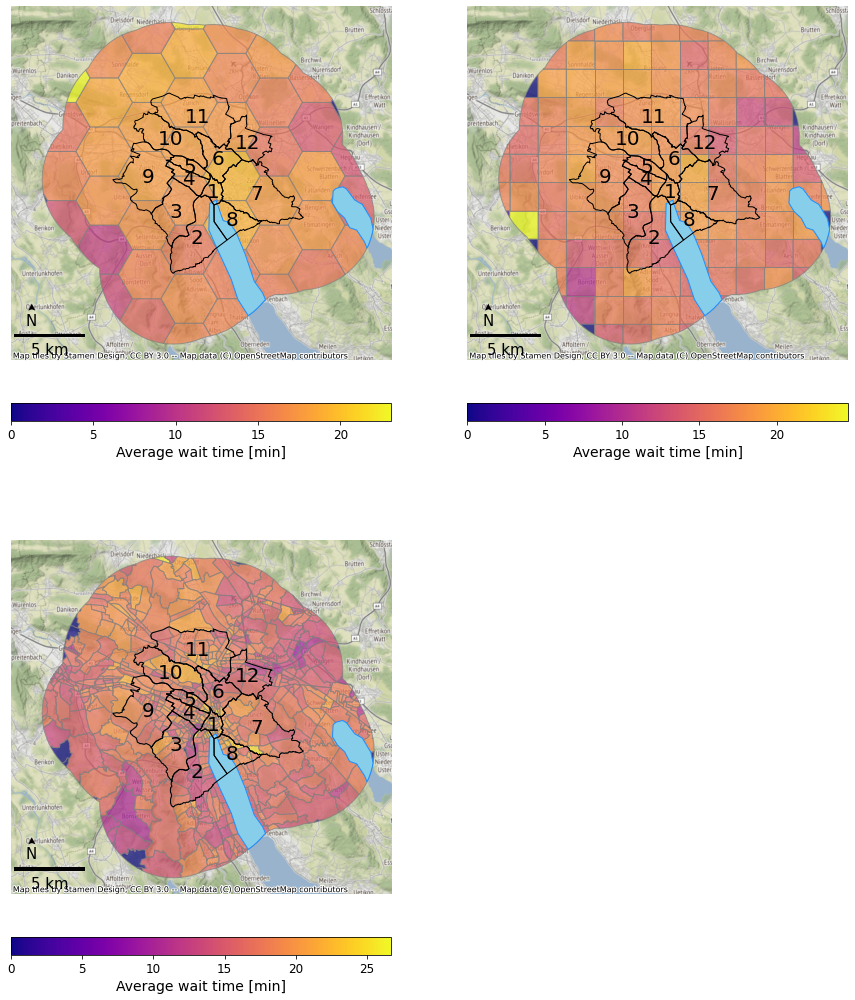

In [55]:
plot_multigrid_wait_time(outputs[100000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:01<00:00, 12.98it/s]


Imputing 120  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:01<00:00, 13.41it/s]


Imputing 684  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:01<00:00, 12.57it/s]


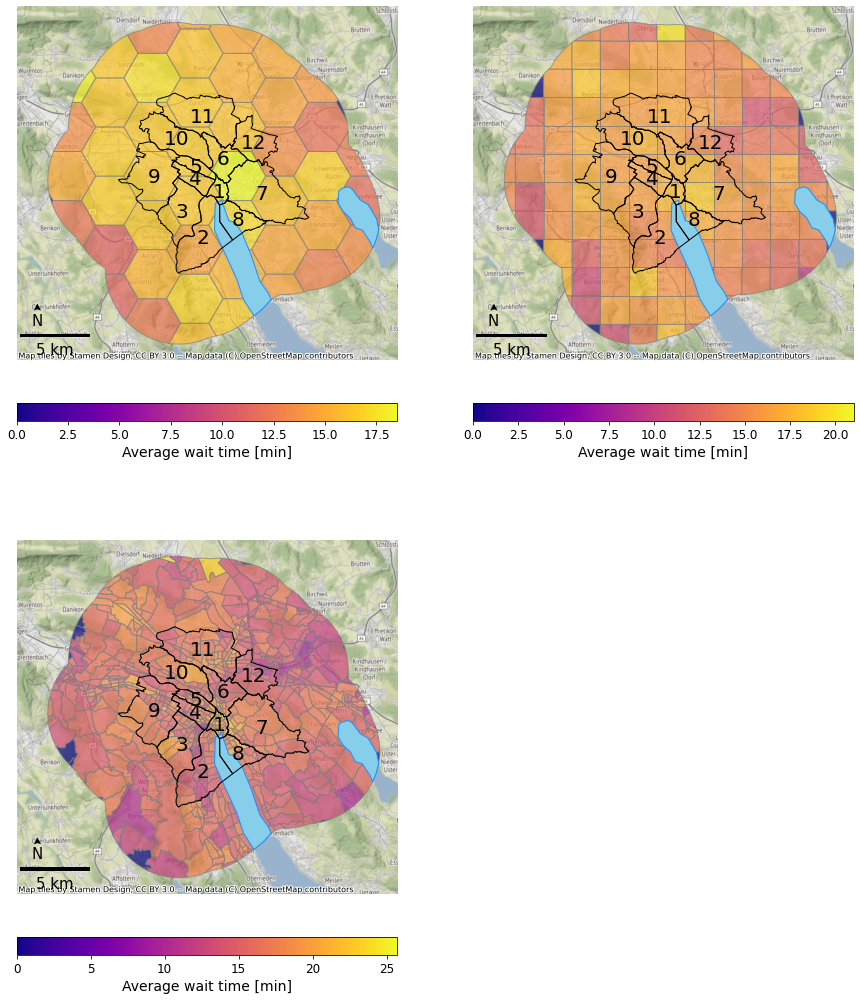

In [56]:
plot_multigrid_wait_time(outputs[200000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:02<00:00, 13.51it/s]


Imputing 120  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:02<00:00, 13.61it/s]


Imputing 684  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:02<00:00, 12.39it/s]


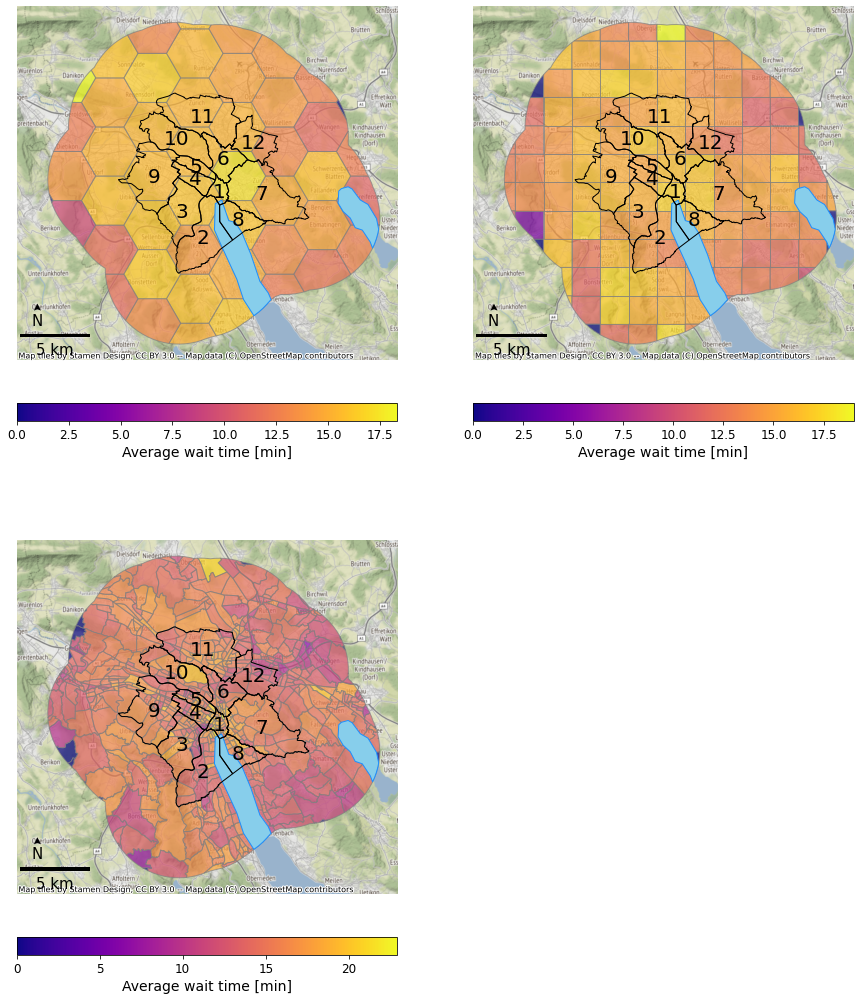

In [57]:
plot_multigrid_wait_time(outputs[300000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:02<00:00, 13.30it/s]


Imputing 120  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:02<00:00, 13.23it/s]


Imputing 684  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:03<00:00, 12.33it/s]


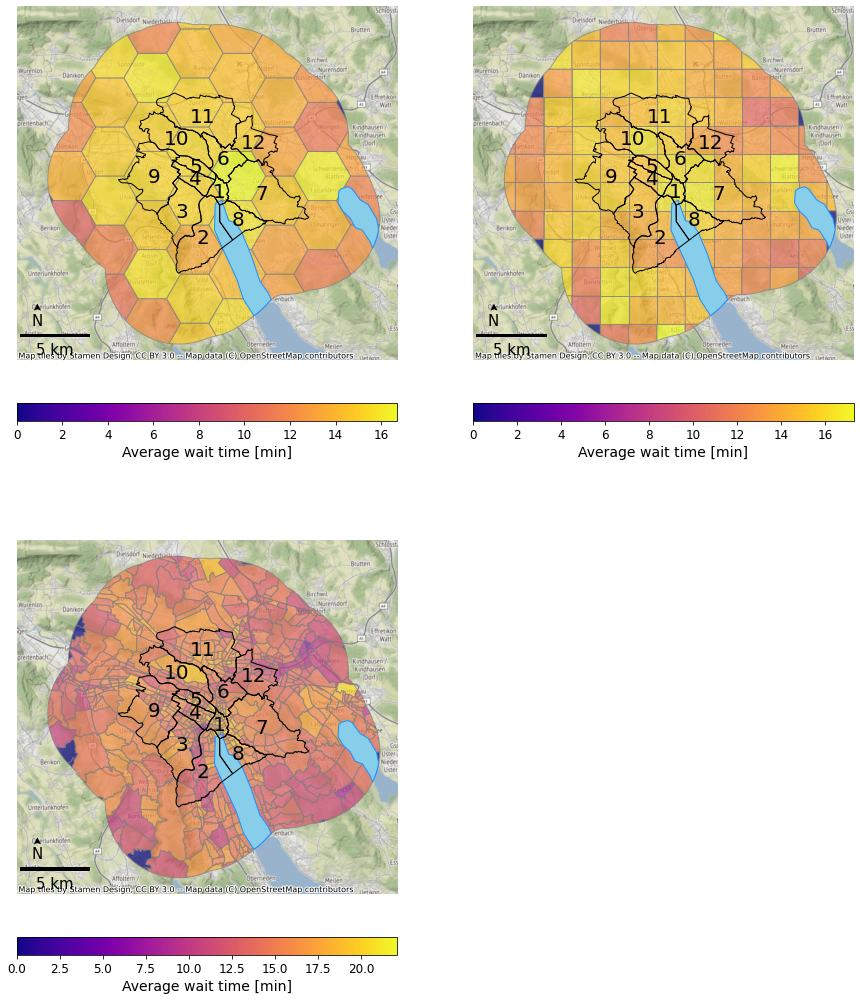

In [58]:
plot_multigrid_wait_time(outputs[400000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:03<00:00, 13.28it/s]


Imputing 120  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:03<00:00, 13.22it/s]


Imputing 684  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:04<00:00, 12.24it/s]


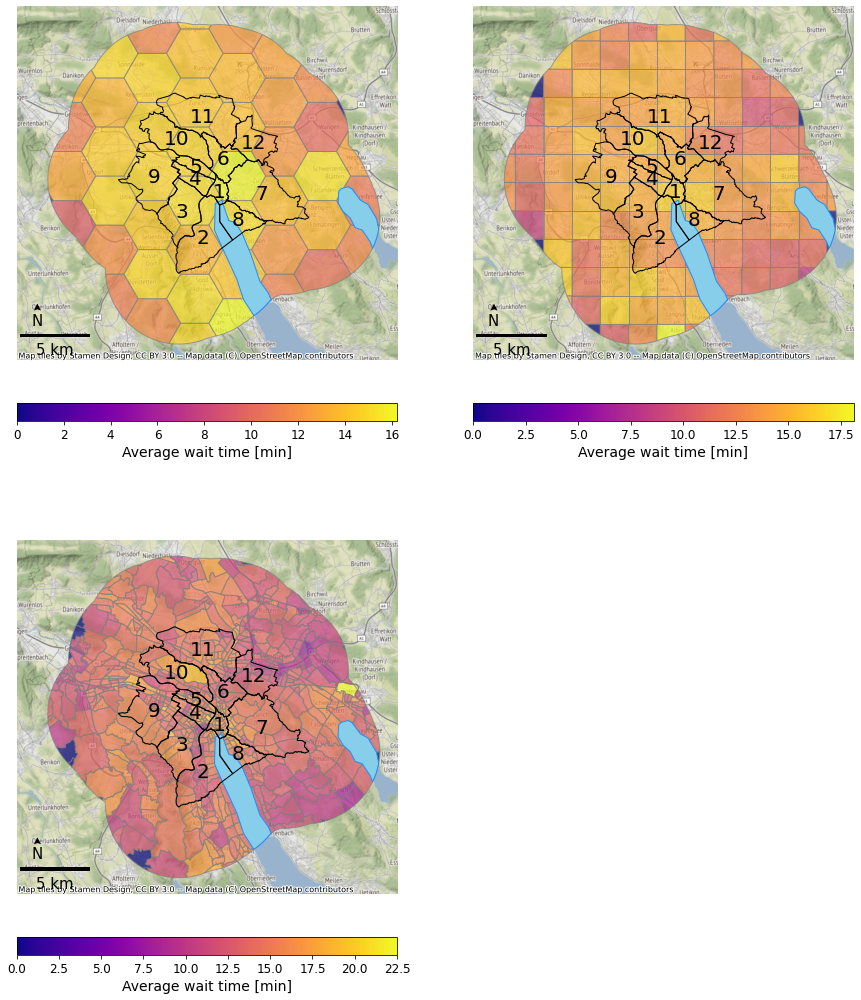

In [59]:
plot_multigrid_wait_time(outputs[500000], zurich_shp_path, lake_path, zurich_districts_path)